In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.io import wavfile
import os
import numpy as np

IMPORTING FILE

Audio data shape is
(35280, 2)


Text(0.5, 1.0, 'Audio signal in time')

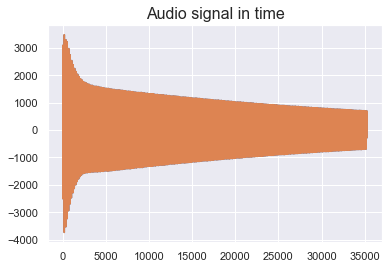

In [2]:
SampleName = "01 - [Prologue]_1.wav" # Audio File
os.chdir('./Training_data/')
SampleRate, Audiodata = wavfile.read(SampleName)

print('Audio data shape is')
print(np.shape(Audiodata))

# Plot the audio signal in time
plt.plot(Audiodata)
plt.title('Audio signal in time',size=16)

FAST FOURIER TRANSFORM \& SPECTRUM

FFT of audio data shape is
(4096,)


(0.0, 0.4)

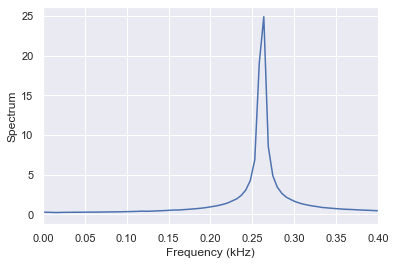

In [3]:
# spectrum
from scipy.fft import fft # fourier transform
m = len(Audiodata) 
FFTSize = 8192 # have to use a multiple of 2 for optimal speed.
#AudioFreq = fft(Audiodata,n=FFTSize,axis=0)
AudioFreq = fft(Audiodata[:,1]*np.hanning(np.shape(Audiodata)[0]),n=FFTSize,axis=0) #with a Hanning window
AudioFreq = AudioFreq[0:int(np.ceil((np.shape(AudioFreq)[0])/2.0))] #Left half of the spectrum
MagFreq = np.abs(AudioFreq) # Magnitude
MagFreq = MagFreq / float(m)

print('FFT of audio data shape is')
print(np.shape(MagFreq))

plt.figure()
freqAxis = np.arange(0,int(np.ceil((m+1)/2.0)), int(np.ceil((m+1)/2.0))*2/FFTSize) * (SampleRate / m);
#freqAxis = np.arange(0,int(np.ceil((m+1)/2.0)), int(np.ceil((m+1)/2.0))/FFTSize) * (SampleRate / m);
plt.plot(freqAxis/1000.0, MagFreq) #Spectrum
plt.xlabel('Frequency (kHz)'); plt.ylabel('Spectrum');
plt.xlim([0, 0.4])

POWER SPECTRUM

(0.0, 0.4)

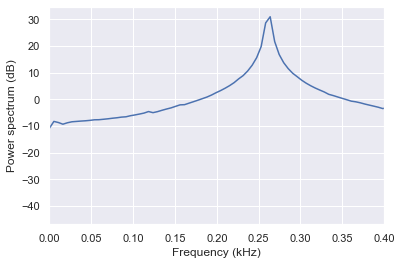

In [4]:
# power spectrum
MagFreq = MagFreq**2
if m % 2 > 0: # ffte odd 
    MagFreq[1:len(MagFreq)] = MagFreq[1:len(MagFreq)] * 2
else:# fft even
    MagFreq[1:len(MagFreq) -1] = MagFreq[1:len(MagFreq) - 1] * 2 

plt.figure()
plt.plot(freqAxis/1000.0, 10*np.log10(MagFreq)) #Power spectrum
plt.xlabel('Frequency (kHz)'); plt.ylabel('Power spectrum (dB)');
plt.xlim([0, 0.4])

FINDING THE FUNDAMENTAL FREQUENCY

In [5]:
# HPS (Harmonic Product Spectrum) Algorithm to determine fundamental frequency

HPSSizeFloat = len(MagFreq)/3.0
HPSSize = int(np.ceil(len(MagFreq))/3.0 + 1)

MagFreq2 = MagFreq.copy().reshape(int(np.ceil(len(MagFreq))/2.0),2).mean(1)[0:HPSSize]
MagFreq3 = np.concatenate([MagFreq.copy(),np.zeros(3 - int(len(MagFreq)) % 3)]).reshape(int(np.ceil(len(MagFreq))/3.0 + 1),3).mean(1)[0:HPSSize]

#MagFreq2 = MagFreq.copy().reshape(int(np.ceil(len(MagFreq))/2.0),2).mean(1)[0:HPCSize]
print(np.shape(MagFreq2))
#MagFreq3 = np.concatenate([MagFreq.copy(),np.zeros(3 - int(len(MagFreq)) % 3)]).reshape(int(np.ceil(len(MagFreq))/3.0 + 1),3).mean(1)[0:HPCSize]
print(np.shape(MagFreq3))

HPS = MagFreq[0:HPSSize]*MagFreq2*MagFreq3
#HPCLog = np.log10(MagFreq[0:HPCSize])*np.log10(MagFreq2)*np.log10(MagFreq3)

freqAxisDownscaled = np.arange(0,int(np.ceil((m+1)/2.0)), int(np.ceil((m+1)/2.0))*6/FFTSize) * (SampleRate / m);
FFLocHPS = np.argmax(HPS[freqAxisDownscaled >= 50]) + int(len(HPS[freqAxisDownscaled < 50])) # don't look below 50 Hz for it, due to noise.



FFLocation = (FFLocHPS-1)*3 # FFLocHPS uses an index that is scaled down by 1/3. Have to reverse that.

#FFLocation = np.argmax(HPC)
#FFLocationLog = np.argmax(HPCLog)
print('Fundamental frequency\'s location is at index... ',FFLocation)
print('Fundamental frequency is...',freqAxis[FFLocation],'Hz.')
#print('(Using power spectrum) Fundamental frequency\'s location is at index... ',FFLocationLog)
#print('(Using power spectrum) Fundamental frequency is...',freqAxis[FFLocationLog],'Hz.')

(1366,)
(1366,)
Fundamental frequency's location is at index...  69
Fundamental frequency is... 371.46881103515625 Hz.


ASSESSING ACCURACY OF THE FF \& MEASURING SPIKES

In [6]:
# Have to ensure the fundamental frequency is accurate. Take loudest spike, get its approximate ratio, round to nearest int.
MaxLoc = np.argmax(MagFreq[freqAxis >= 50]) + int(len(MagFreq[freqAxis < 50])) # don't look below 50 Hz for it, due to noise.
MaxRatio = np.max([np.round(freqAxis[MaxLoc]/freqAxis[FFLocation]), 1])
#MaxRatioLog = np.round(freqAxis[MaxLoc]/freqAxis[FFLocationLog])
print('The loudest ratio is ',MaxRatio)
#print('(Using power spectrum) The loudest ratio is ',MaxRatioLog)

FFreq = freqAxis[MaxLoc]/MaxRatio
print('Corrected fundamental frequency is ',FFreq,' Hz.')

MagFreqLog = 10*np.log10(MagFreq)
FFreqLoc = np.argmin(np.abs(freqAxis - FFreq))
print('Closest match found at index ',FFreqLoc)

# If the frequency immediately on either side of each "spike" is louder, make that the new spike.
FFreqLoc = FFreqLoc - ((MagFreqLog <= np.roll(MagFreqLog,1)) & (np.roll(MagFreqLog,-1) <= np.roll(MagFreqLog,1))) #if the left entry is >= the entry and the right entry, then make the left entry the new spike location
FFreqLoc = FFreqLoc + ((MagFreqLog <= np.roll(MagFreqLog,-1)) & (np.roll(MagFreqLog,1) <= np.roll(MagFreqLog,-1)))  #if the right entry is >= the entry and the left entry, then make the right entry the new spike location

numberSpikes = 20
Multiples = [FFreq*i for i in np.arange(0,numberSpikes)]
Multiples[0] = FFreq/2 # It turns out, telling the YM2612 to use the "0th" multiple means 1/2 the FF.
print(Multiples)

MultiplesLoc = [np.argmin(np.abs(freqAxis - i)) for i in Multiples]
print(MultiplesLoc)

# Next, make an integer ratio-indexed list of the amplitudes!

MultiplesMag = MagFreq[MultiplesLoc]
print(MultiplesMag)

MultiplesdB = MagFreqLog[MultiplesLoc]
print(MultiplesdB)

The loudest ratio is  1.0
Corrected fundamental frequency is  263.79669189453125  Hz.
Closest match found at index  49
[131.89834594726562, 263.79669189453125, 527.5933837890625, 791.3900756835938, 1055.186767578125, 1318.9834594726562, 1582.7801513671875, 1846.5768432617188, 2110.37353515625, 2374.1702270507812, 2637.9669189453125, 2901.7636108398438, 3165.560302734375, 3429.3569946289062, 3693.1536865234375, 3956.9503784179688, 4220.7470703125, 4484.543762207031, 4748.3404541015625, 5012.137145996094]
[24, 49, 98, 147, 196, 245, 294, 343, 392, 441, 490, 539, 588, 637, 686, 735, 784, 833, 882, 931]
[3.46080249e-01 1.24053034e+03 3.55408349e-01 8.41128443e-02
 2.22068712e-02 1.35146583e-02 7.97451996e-03 5.42737697e-03
 4.38594088e-03 3.19160452e-03 2.75467948e-03 2.27637778e-03
 1.99532921e-03 1.68847586e-03 1.58140644e-03 1.37281286e-03
 1.26366013e-03 1.14571481e-03 9.94459494e-04 8.87700221e-04]
[ -4.60823185  30.93607392  -4.49272375 -10.75137681 -16.53512626
 -18.69194929 -20.982